# Joint-Space Inverse Dynamics

This notebook shows how to use the Python bindings of the C++ library TSID to control a manipulator in joint space.

In [1]:
import sys
sys.path.append('..')

import numpy as np
from numpy import nan
from numpy.linalg import norm as norm
import matplotlib.pyplot as plt
import plot_utils as plut
import time
import pinocchio as pin
import tsid
import gepetto.corbaserver
import subprocess
import os

import ur5_conf as conf

USE_VIEWER = 1

Create a RobotWrapper specifying the URDF file describing the robot.

In [2]:
vector = pin.StdVec_StdString()
vector.extend(item for item in conf.path)
robot = tsid.RobotWrapper(conf.urdf, vector, False)
model = robot.model()

Create an InverseDynamicsFormulationAccForce object to collect all tasks together and transform them into a QP.

In [3]:
formulation = tsid.InverseDynamicsFormulationAccForce("tsid", robot, False)
q0 = conf.q0
v0 = np.zeros(robot.nv)
formulation.computeProblemData(0.0, q0, v0)

Create a TaskJointPosture to control the joint configuration of the robot. Set the proportional and derivative gains $k_p$ and $k_d$. Add the task to the formulation object with a user-specified weight to the priority level 1 (1 corresponds to the cost function, 0 corresponds to the constraints).

In [4]:
postureTask = tsid.TaskJointPosture("task-posture", robot)
postureTask.setKp(conf.kp_posture * np.ones(robot.nv))
postureTask.setKd(2.0 * np.sqrt(conf.kp_posture) * np.ones(robot.nv))
priorityLevel = 1
transitionTime = 0.0
formulation.addMotionTask(postureTask, conf.w_posture, priorityLevel, transitionTime)

True

Create a constant trajectory in Euclidian space to use as reference for the joint posture task.

In [5]:
trajPosture = tsid.TrajectoryEuclidianConstant("traj_joint", q0)
postureTask.setReference(trajPosture.computeNext())

Create a TaskJointBounds to specify the joint velocity limits and add it to the formulation object with priority level 0 (which means it is added as a hard constraint in the QP).

In [6]:
v_max = conf.v_max_scaling * model.velocityLimit
v_min = -v_max
jointBoundsTask = tsid.TaskJointBounds("task-joint-bounds", robot, conf.dt)
jointBoundsTask.setVelocityBounds(v_min, v_max)
priorityLevel = 0
formulation.addMotionTask(jointBoundsTask, conf.w_joint_bounds, priorityLevel, transitionTime)

True

Create a QP solver for solving the TSID QP problem.

In [7]:
solver = tsid.SolverHQuadProgFast("qp solver")
solver.resize(formulation.nVar, formulation.nEq, formulation.nIn)

Run the viewer if it's not already running.

In [8]:
if(USE_VIEWER):
    robot_display = pin.RobotWrapper.BuildFromURDF(conf.urdf, [conf.path, ])
    l = subprocess.getstatusoutput("ps aux |grep 'gepetto-gui'|grep -v 'grep'|wc -l")
    if int(l[1]) == 0:
        os.system('gepetto-gui &')
    time.sleep(1)
    gepetto.corbaserver.Client()
    robot_display.initViewer(loadModel=True)
    robot_display.displayCollisions(False)
    robot_display.displayVisuals(True)
    robot_display.display(q0)
#    robot_display.viewer.gui.setCameraTransform(0, conf.CAMERA_TRANSFORM)

Create empty arrays to store the simulation trajectories.

In [9]:
N = conf.N_SIMULATION
tau    = np.empty((robot.na, N))*nan
q      = np.empty((robot.nq, N+1))*nan
v      = np.empty((robot.nv, N+1))*nan
dv     = np.empty((robot.nv, N+1))*nan
q_ref  = np.empty((robot.nq, N))*nan
v_ref  = np.empty((robot.nv, N))*nan
dv_ref = np.empty((robot.nv, N))*nan
dv_des = np.empty((robot.nv, N))*nan
samplePosture = trajPosture.computeNext()

Specify amplitude, phase and frequency of the sinusoidal joint trajectory to track.

In [10]:
amp                  = np.array([0.2, 0.3, 0.4, 0.0, 0.0, 0.0])           # amplitude
phi                  = np.array([0.0, 0.5*np.pi, 0.0, 0.0, 0.0, 0.0])     # phase
two_pi_f             = 2*np.pi*np.array([1.0, 0.5, 0.3, 0.0, 0.0, 0.0])   # frequency (time 2 PI)
two_pi_f_amp         = np.multiply(two_pi_f, amp)
two_pi_f_squared_amp = np.multiply(two_pi_f, two_pi_f_amp)

Start simulating the system. At each loop:
* compute the reference joint sinusoidal trajectory and set it to the posture task
* compute the QP problem data using formulation
* solve the QP and get the joint accelerations
* integrate the accelerations to update the robot state

In [11]:
t = 0.0
dt = conf.dt
q[:,0], v[:,0] = q0, v0

for i in range(0, N):
    time_start = time.time()
    
    # set reference trajectory
    q_ref[:,i]  = q0 +  amp * np.sin(two_pi_f*t + phi)
    v_ref[:,i]  = two_pi_f_amp * np.cos(two_pi_f*t + phi)
    dv_ref[:,i] = -two_pi_f_squared_amp * np.sin(two_pi_f*t + phi)
    samplePosture.pos(q_ref[:,i])
    samplePosture.vel(v_ref[:,i])
    samplePosture.acc(dv_ref[:,i])
    postureTask.setReference(samplePosture)

    HQPData = formulation.computeProblemData(t, q[:,i], v[:,i])
    sol = solver.solve(HQPData)
    if(sol.status!=0):
        print("Time %.3f QP problem could not be solved! Error code:"%t, sol.status)
        break
    
    tau[:,i] = formulation.getActuatorForces(sol)
    dv[:,i] = formulation.getAccelerations(sol)
    dv_des[:,i] = postureTask.getDesiredAcceleration

    if i%conf.PRINT_N == 0:
        print("Time %.3f"%(t))
        print("\ttracking err %s: %.3f"%(postureTask.name.ljust(20,'.'), norm(postureTask.position_error, 2)))

    # numerical integration
    v_mean = v[:,i] + 0.5*dt*dv[:,i]
    v[:,i+1] = v[:,i] + dt*dv[:,i]
    q[:,i+1] = pin.integrate(model, q[:,i], dt*v_mean)
    t += conf.dt
    
    if i%conf.DISPLAY_N == 0: 
        robot_display.display(q[:,i])

    time_spent = time.time() - time_start
    if(time_spent < conf.dt): time.sleep(conf.dt-time_spent)

# PLOT STUFF
time = np.arange(0.0, N*conf.dt, conf.dt)

Time 0.000
	tracking err task-posture........: 0.300
Time 1.000
	tracking err task-posture........: 0.472
Time 2.000
	tracking err task-posture........: 0.334
Time 3.000
	tracking err task-posture........: 0.218
Time 4.000
	tracking err task-posture........: 0.145
Time 5.000
	tracking err task-posture........: 0.102
Time 6.000
	tracking err task-posture........: 0.074
Time 7.000
	tracking err task-posture........: 0.054


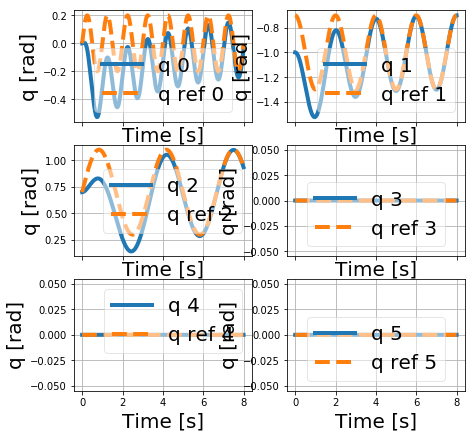

In [12]:
(f, ax) = plut.create_empty_figure(int(robot.nv/2),2)
ax = ax.reshape(robot.nv)
for i in range(robot.nv):
    ax[i].plot(time, q[i,:-1], label='q '+str(i))
    ax[i].plot(time, q_ref[i,:], '--', label='q ref '+str(i))
    ax[i].set_xlabel('Time [s]')
    ax[i].set_ylabel('q [rad]')
    leg = ax[i].legend()
    leg.get_frame().set_alpha(0.5)
plt.show()

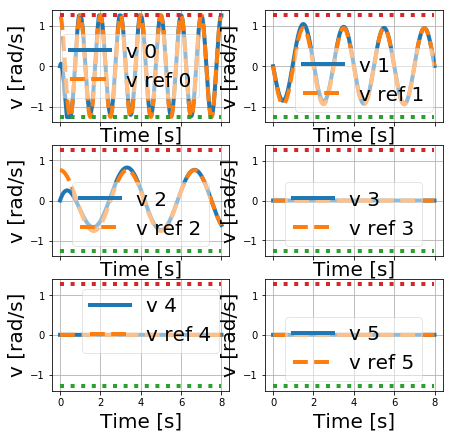

In [13]:
(f, ax) = plut.create_empty_figure(int(robot.nv/2),2)
ax = ax.reshape(robot.nv)
for i in range(robot.nv):
    ax[i].plot(time, v[i,:-1], label='v '+str(i))
    ax[i].plot(time, v_ref[i,:], '--', label='v ref '+str(i))
    ax[i].plot([time[0], time[-1]], 2*[v_min[i]], ':')
    ax[i].plot([time[0], time[-1]], 2*[v_max[i]], ':')
    ax[i].set_xlabel('Time [s]')
    ax[i].set_ylabel('v [rad/s]')
    leg = ax[i].legend()
    leg.get_frame().set_alpha(0.5)
plt.show()

In [ ]:
(f, ax) = plut.create_empty_figure(int(robot.nv/2),2)
ax = ax.reshape(robot.nv)
for i in range(robot.nv):
    ax[i].plot(time, dv[i,:-1], label='dv '+str(i))
    ax[i].plot(time, dv_ref[i,:], '--', label='dv ref '+str(i))
    ax[i].plot(time, dv_des[i,:], ':', label='dv des '+str(i))
    ax[i].set_xlabel('Time [s]')
    ax[i].set_ylabel('dv [rad/s^2]')
    leg = ax[i].legend()
    leg.get_frame().set_alpha(0.5)
plt.show()

In [ ]:
(f, ax) = plut.create_empty_figure(int(robot.nv/2),2)
ax = ax.reshape(robot.nv)
for i in range(robot.nv):
    ax[i].plot(time, tau[i,:], label='tau '+str(i))
    ax[i].set_xlabel('Time [s]')
    ax[i].set_ylabel('tau [Nm]')
    leg = ax[i].legend()
    leg.get_frame().set_alpha(0.5)
plt.show()